In [94]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

In [95]:
df = pd.read_pickle('../data/raw/model_df.pkl')

In [96]:
import nltk
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer('\w+|\(\d+\*\d+\)|\(\d+.\d+,\d+\)')

In [97]:
regexed = []

for desc in list(df.model_description):
    regexed.append([x.lower() for x in tokenizer.tokenize(desc)])

In [98]:
import gensim.downloader as api

In [72]:
wv = api.load('word2vec-google-news-300')

[--------------------------------------------------] 1.4% 23.4/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=-------------------------------------------------] 3.7% 61.9/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[===-----------------------------------------------] 6.0% 100.1/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[====----------------------------------------------] 8.3% 137.4/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=====---------------------------------------------] 10.5% 174.3/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[======--------------------------------------------] 12.7% 210.7/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=======-------------------------------------------] 14.7% 244.8/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[========------------------------------------------] 16.8% 280.1/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=========-----------------------------------------] 19.0% 316.5/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[===========---------------------------------------] 22.5% 374.4/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[============--------------------------------------] 25.9% 431.4/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[==============------------------------------------] 29.1% 483.8/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[================----------------------------------] 32.5% 541.2/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=================---------------------------------] 34.5% 573.8/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[===================-------------------------------] 38.2% 634.5/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[====================------------------------------] 40.3% 669.9/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[======================----------------------------] 44.2% 735.6/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=======================---------------------------] 46.8% 778.2/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=========================-------------------------] 50.2% 834.3/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[==========================------------------------] 53.8% 894.4/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[============================----------------------] 56.3% 936.0/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=============================---------------------] 59.3% 985.3/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[==============================--------------------] 61.2% 1017.7/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[===============================-------------------] 63.4% 1054.2/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[================================------------------] 65.6% 1091.4/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[==================================----------------] 68.9% 1145.6/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[===================================---------------] 71.9% 1195.1/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[====================================--------------] 73.9% 1228.9/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[======================================------------] 77.5% 1288.3/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[========================================----------] 80.4% 1336.1/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=========================================---------] 82.6% 1373.2/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[==========================================--------] 85.6% 1423.8/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[===========================================-------] 87.9% 1462.1/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[============================================------] 89.9% 1494.8/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[===============================================---] 94.2% 1565.8/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=================================================-] 98.1% 1631.3/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [99]:
def get_avg(phrase, wv):
    vec_result = []
    tokens = phrase.split(' ')    
    for t in tokens:
        if t in wv:
            vec_result.append(wv[t].tolist())
        else:
            #300 is the dimension of the Google wv model
            vec_result.append([0.0]*300)    
    return np.average(vec_result, axis=0)

In [101]:
get_avg('this 3d model sofa has a fully textured detailed design', wv)

array([ 3.22265625e-02, -2.88940430e-02, -2.28973389e-02,  1.06347656e-01,
        2.54211426e-02,  1.26770020e-02,  5.33508301e-02, -1.26373291e-01,
        3.60107422e-02,  5.10498047e-02, -1.04101562e-01, -7.87231445e-02,
       -7.68432617e-03, -3.55468750e-02, -7.52166748e-02,  4.91821289e-02,
       -1.13403320e-02,  3.73046875e-02, -5.38818359e-02, -6.73461914e-02,
       -7.85644531e-02,  4.57031250e-02, -2.46337891e-02, -1.82739258e-02,
       -3.96728516e-05,  1.18408203e-03, -3.35327148e-02,  6.91528320e-02,
       -1.19720459e-02, -1.49804688e-01, -3.84521484e-02,  1.05810547e-01,
       -8.76220703e-02,  9.65694427e-02, -1.43447876e-02, -9.17060852e-02,
       -8.34960938e-03, -1.06506348e-02, -1.94580078e-02, -3.25420380e-02,
        5.65124512e-02, -2.81982422e-03,  3.28979492e-02,  6.49616241e-02,
        7.03369141e-02, -5.50811768e-02, -5.28320313e-02,  2.06298828e-03,
        9.82727051e-02,  3.93310547e-02,  7.36083984e-02, -1.13281250e-02,
       -3.97949219e-03, -

In [85]:
np.quantile(df['price_usd'], [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

array([4.750e+00, 6.000e+00, 8.000e+00, 1.000e+01, 1.448e+01, 1.899e+01,
       2.414e+01, 3.900e+01, 8.900e+01, 1.000e+04])

In [86]:
price_df = df[df['price_usd'] < 1000]

In [87]:
X = np.array([get_avg(phrase, wv) for phrase in price_df['model_description']])
y = np.array(price_df['price_usd'])

In [90]:
from sklearn.ensemble import RandomForestRegressor

# baseline including zero parameters
reg = RandomForestRegressor(random_state=0, max_depth=5, n_jobs=8)


In [ ]:
from gensim.test.utils import common_texts
from gensim.models import Phrases



In [135]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

#10-fold cross validation
kf = KFold(n_splits=10)
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]    
    reg.fit(X_train, y_train)
    
    print(mean_squared_error(y_test, reg.predict(X_test)) ** 0.5)

38.86260494044945
38.898444160425754
39.60405279471748
34.40896510063067
40.485906250669004
37.770815038395725
43.33310338213382
43.088396238041575
44.098067881202915
40.2219829136661


<bound method RegressorMixin.score of RandomForestRegressor(random_state=0)>

In [3]:
from textblob import TextBlob

In [4]:
example_blob = TextBlob(list(df.model_description)[0])

In [5]:
blobs = []

for x in df.model_description:
    blobs.append(TextBlob(x))

In [6]:
polarities = []

for blob in blobs:
    polarities.append(blob.polarity)

(array([7.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00, 3.0000e+00,
        5.1000e+01, 1.2000e+01, 2.4000e+01, 0.0000e+00, 1.2000e+01,
        1.7000e+01, 2.0000e+00, 3.9000e+01, 1.4000e+01, 2.0000e+01,
        3.2000e+02, 1.2100e+02, 1.1500e+02, 1.7900e+02, 3.2400e+02,
        2.6000e+02, 6.1600e+02, 9.4900e+02, 1.0400e+03, 1.8280e+03,
        1.5743e+04, 3.7590e+03, 5.4970e+03, 7.1120e+03, 6.8620e+03,
        6.8310e+03, 4.1770e+03, 3.9630e+03, 2.0520e+03, 2.5200e+03,
        1.0240e+03, 6.4400e+02, 6.4500e+02, 3.6000e+02, 1.8600e+02,
        7.9000e+01, 6.6000e+01, 2.2500e+02, 4.2000e+01, 1.9000e+01,
        4.6000e+01, 5.5000e+01, 2.8000e+01, 1.0000e+00, 1.4800e+02]),
 array([-1.  , -0.96, -0.92, -0.88, -0.84, -0.8 , -0.76, -0.72, -0.68,
        -0.64, -0.6 , -0.56, -0.52, -0.48, -0.44, -0.4 , -0.36, -0.32,
        -0.28, -0.24, -0.2 , -0.16, -0.12, -0.08, -0.04,  0.  ,  0.04,
         0.08,  0.12,  0.16,  0.2 ,  0.24,  0.28,  0.32,  0.36,  0.4 ,
         0.44,  0.48,  0.52,  0.56

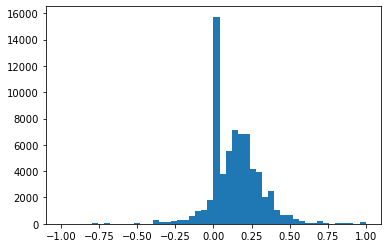

In [10]:
plt.hist(polarities, bins=50)

In [15]:
np.array(blobs)[np.array(polarities) < -.45]

array([TextBlob("Restoration Hardware Dixon Upholstered Base Leather Armchair https://www.restorationhardware.com/catalog/product/product.jsp?productId=prod17510046&categoryId=search V-Ray render and materials All textures include in *.rar files Lighting setup is not included in the file "),
       TextBlob("2301CarpenterSofaC3seats_2280x974x1020 2638100F Fabric JY5680-3 2638800F Fabric ST9-4 230-1 Carpenter Sofa C 3-seats 2280x974x1020Polys: 59547 Verts: c "),
       TextBlob("Product: Tika lantern steel base Materials: HDPE wicker | powder coated aluminium frame | steel base Dimensions: 59 cm x 35 cm "),
       TextBlob("Please let me know before making bad comments for mistakes and problems so l can fix them. And please do not hesitate to ask questions.   In the format ztl (Zbrush)Separately hair,body,dress  "),
       TextBlob("army jeep 3d model with 2k and 4k pbr textures.made in 3d max 2014 and render in marmoset toolbag. model characteristics: .quad based topology .uv unwrapped

In [126]:
import numpy as np

np.array(blobs)[np.array(polarities) < -0.5]

array([TextBlob("Restoration Hardware Dixon Upholstered Base Leather Armchair https://www.restorationhardware.com/catalog/product/product.jsp?productId=prod17510046&categoryId=search V-Ray render and materials All textures include in *.rar files Lighting setup is not included in the file "),
       TextBlob("2301CarpenterSofaC3seats_2280x974x1020 2638100F Fabric JY5680-3 2638800F Fabric ST9-4 230-1 Carpenter Sofa C 3-seats 2280x974x1020Polys: 59547 Verts: c "),
       TextBlob("Product: Tika lantern steel base Materials: HDPE wicker | powder coated aluminium frame | steel base Dimensions: 59 cm x 35 cm "),
       TextBlob("Please let me know before making bad comments for mistakes and problems so l can fix them. And please do not hesitate to ask questions.   In the format ztl (Zbrush)Separately hair,body,dress  "),
       TextBlob("army jeep 3d model with 2k and 4k pbr textures.made in 3d max 2014 and render in marmoset toolbag. model characteristics: .quad based topology .uv unwrapped

(array([1.2000e+01, 9.9000e+01, 3.8800e+02, 7.6300e+02, 4.6930e+03,
        4.0493e+04, 1.8023e+04, 2.8590e+03, 4.3100e+02, 2.7800e+02]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 10 Patch objects>)

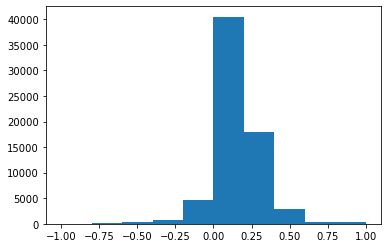

In [119]:
plt.hist(polarities)

In [100]:
example_blob.noun_phrases

WordList(['high quality 3d models', 'barazza', 'reasonable amount', 'accurate grid', 'sinks cod', 'sinks cod', 'sinks cod', 'sinks cod', 'sinks cod', 'sinks cod', 'sinks cod', 'geometry', 'polygonal quads', 'turbosmooth', 'polys', 'verts', 'turbosmooth', 'polys', 'verts'])

In [89]:
df.model_description.apply(lambda x: TextBlob(x).tags)

KeyboardInterrupt: 

In [3]:
df

,modeler,modeler_response,modeler_ratings,tags,views,likes,review_count,comments,price,pic_count,model_description,model_details,price_usd,tag_count,response_time
0,andriy115599,"{'percent': 100, 'time': '5.0h'}","{'avg_rating': 3.9, 'num_rating': 14}","[accessorie, appliance, barazza, furniture, ki...",351,0,0,"{'authors': [], 'texts': [], 'datetimes': []}",$6.00,30,High quality 3d models of Barazza. The models ...,"{'model_id': '801556', 'geometry': 'Subdivisio...",6.00,7,5.0
1,sinartur,"{'percent': 0, 'time': 0}","{'avg_rating': 0, 'num_rating': 0}","[bed, furniture, pillow, comfort, modern, styl...",96,1,0,"{'authors': ['GGAF'], 'texts': ['cool'], 'date...",$14.99,10,This 3d model Lipende sofa has a fully texture...,"{'model_id': '2095846', 'geometry': 'Polygon m...",14.99,19,0.0
2,hq3dmodel,"{'percent': 0, 'time': 0}","{'avg_rating': 5.0, 'num_rating': 1}","[rug, carpet, fur, interior, floor, cloth, woo...",15,0,0,"{'authors': [], 'texts': [], 'datetimes': []}",$5.00,8,The set consists of 3 rugs. All high quality t...,"{'model_id': '2418972', 'geometry': 'Polygon m...",5.00,20,0.0
3,-snake-,"{'percent': 0, 'time': 0}","{'avg_rating': 0, 'num_rating': 0}","[aquanet, modena, furniture, sink, mixer, mirr...",19,0,0,"{'authors': [], 'texts': [], 'datetimes': []}",$7.00,9,Furniture set Modena 65/85/100 White gloss. Di...,"{'model_id': '2372429', 'geometry': 'Polygon m...",7.00,18,0.0
4,zifir3d,"{'percent': 88, 'time': '0.2h'}","{'avg_rating': 4.7, 'num_rating': 33}","[flexform, ettore, sofa, divan, lounge, pillow...",77,2,0,"{'authors': [], 'texts': [], 'datetimes': []}",$39.00,8,Flexform Ettore https://www.flexform.it/en/pro...,"{'model_id': '2251378', 'geometry': 'Polygon m...",39.00,21,0.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,aviato,"{'percent': 100, 'time': '68.5h'}","{'avg_rating': 4.3, 'num_rating': 7}","[sink, washbasin, stone, oval, invoice, marble...",43,0,0,"{'authors': [], 'texts': [], 'datetimes': []}",$13.00,5,Stone sink and faucet Grohe Atrio 32129 Suitab...,"{'model_id': '2252178', 'geometry': 'Polygon m...",13.00,10,68.5
996,ikhlasmiftah,"{'percent': 67, 'time': '26.3h'}","{'avg_rating': 2.5, 'num_rating': 2}","[car, vehicle, wheel, automotive, tire, headli...",148,0,0,"{'authors': [], 'texts': [], 'datetimes': []}",$19.00,4,Ready to render at sketch up 2015 with vray 2 ...,"{'model_id': '2029813', 'geometry': '- ', 'pol...",19.00,15,26.3
997,lockemreality,"{'percent': 50, 'time': '48.0h'}","{'avg_rating': 4.4, 'num_rating': 8}","[anchovy, can, protein, food, cooked, burnt, g...",237,0,0,"{'authors': [], 'texts': [], 'datetimes': []}",$2.00,7,High quality low poly model of anchovies. This...,"{'model_id': '904538', 'geometry': 'Polygon me...",2.00,9,48.0
998,ineedsomesleep17,"{'percent': 0, 'time': 0}","{'avg_rating': 4.0, 'num_rating': 5}","[harri, more, trixy, ozzio, console, consolle,...",89,0,0,"{'authors': [], 'texts': [], 'datetimes': []}",$2.00,7,3DS MAX 2015 AND VRAY RENDER MAX+FBX+3DS FORMAT,"{'model_id': '2003192', 'geometry': '- ', 'pol...",2.00,19,0.0


In [11]:
comments = df['comments'].apply(lambda x: x if len(x['authors']) > 0 else None).dropna()

In [23]:
df['comments'][1]

1    {'authors': ['GGAF'], 'texts': ['cool'], 'date...
1        {'authors': [], 'texts': [], 'datetimes': []}
1        {'authors': [], 'texts': [], 'datetimes': []}
1        {'authors': [], 'texts': [], 'datetimes': []}
1        {'authors': [], 'texts': [], 'datetimes': []}
                           ...                        
1        {'authors': [], 'texts': [], 'datetimes': []}
1        {'authors': [], 'texts': [], 'datetimes': []}
1        {'authors': [], 'texts': [], 'datetimes': []}
1        {'authors': [], 'texts': [], 'datetimes': []}
1        {'authors': [], 'texts': [], 'datetimes': []}
Name: comments, Length: 69, dtype: object

(array([6.5212e+04, 1.5720e+03, 8.7300e+02, 1.9400e+02, 1.6400e+02,
        1.5000e+01, 5.0000e+00, 2.0000e+00, 0.0000e+00, 2.0000e+00]),
 array([ 0. ,  2.1,  4.2,  6.3,  8.4, 10.5, 12.6, 14.7, 16.8, 18.9, 21. ]),
 <a list of 10 Patch objects>)

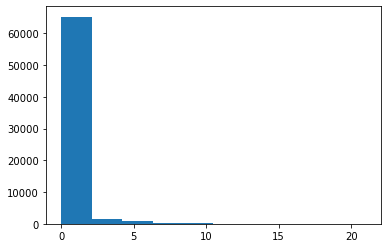

In [34]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

plt.hist(df['comments'].apply(lambda x: len(x['authors'])))

In [49]:
comments.values

array([{'authors': ['GGAF'], 'texts': ['cool'], 'datetimes': [datetime.datetime(2019, 9, 16, 17, 5)]},
       {'authors': ['piyushp7879', 'aanthony-jegu', 'ppukamakara', 'sixam'], 'texts': ['Nice', 'This is great work, great models and the support from the team Sixam is really profesional. I had some issue importing the models correctly in C4D and they helped me within the hour. So yes Highly recommended. ', 'Gorgeous', 'Thank you for your feedback. :)'], 'datetimes': [datetime.datetime(2019, 8, 1, 3, 36), datetime.datetime(2019, 10, 31, 13, 46), datetime.datetime(2020, 2, 10, 9, 24), datetime.datetime(2020, 2, 10, 9, 47)]},
       {'authors': ['Dolphin-GS'], 'texts': ['Good'], 'datetimes': [datetime.datetime(2018, 1, 25, 4, 46)]},
       ...,
       {'authors': ['PBRCool'], 'texts': ['superb!'], 'datetimes': [datetime.datetime(2018, 11, 2, 4, 49)]},
       {'authors': ['lyivan'], 'texts': ['nice'], 'datetimes': [datetime.datetime(2018, 11, 24, 8, 15)]},
       {'authors': ['Kado3D'], 

In [92]:
model_detail_df = pd.DataFrame(list(df['model_details']))

In [102]:
model_detail_df

binary_cols = ['animated', 'rigged', 'vr/ar/low-poly', 'pbr', 'textures', 'materials', 'uv_mapping', 'plugins_used']

In [106]:
model_detail_df = model_detail_df.dropna()

In [107]:
for col in binary_cols:
    model_detail_df[col] = model_detail_df[col].astype(int)

In [132]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.corpus import stopwords

In [134]:
vectorizer = CountVectorizer(stop_words = stopwords)
transformer = TfidfTransformer()

In [ ]:
trainVectorizerArray = vectorizer.fit_transform(train_set).toarray()
testVectorizerArray = vectorizer.transform(test_set).toarray()

In [110]:
# importing one hot encoder 
from sklearn.preprocessing import OneHotEncoder
# creating one hot encoder object 
ohe = OneHotEncoder()

In [116]:
ohe.fit_transform(model_detail_df[['unwrapped_uvs', 'geometry']].values.reshape(-1, 1)).toarray()

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [118]:
model_detail_df['geometry'].value_counts()

Polygon mesh            47652
-                        9578
Subdivision ready        1613
Subdivision              1572
Other                    1153
Nurbs                     243
Polygon                   181
Choose Geometry           111
                            5
选择几何                        2
Выбрать геометрию           2
Odaberite Geometriju        1
Elige La Geometría          1
Name: geometry, dtype: int64

In [122]:
valid_df = model_detail_df.drop(['model_id', 'geometry', 'unwrapped_uvs'], axis=1)

In [129]:
pretext_df = pd.merge(df.iloc[valid_df.index, :].drop(['modeler', 'modeler_response', 'modeler_ratings', 'tags', 'comments', 'price', 'model_details'], axis=1), valid_df, left_index=True, right_index=True)

In [130]:
pretext_df.head()

,views,likes,review_count,pic_count,model_description,price_usd,tag_count,response_time,polygons,vertices,animated,rigged,vr/ar/low-poly,pbr,textures,materials,uv_mapping,plugins_used
0,351,0,0,30,High quality 3d models of Barazza. The models ...,6.0,7,5.0,273224,365483,0,0,1,0,1,1,1,0
0,170,0,0,2,Cast iron plantSorry I don't know how to expor...,4.0,6,5.4,273224,365483,0,0,1,0,1,1,1,0
0,103,1,0,6,Coffee table Tray Rimadesio Dimensions: W x D ...,12.0,16,0.0,273224,365483,0,0,1,0,1,1,1,0
0,43,1,0,5,Chicken Turkey Leg Thigh Photogrammetry 3d Mod...,4.0,15,48.0,273224,365483,0,0,1,0,1,1,1,0
0,1330,2,0,25,HIGHLY DETAILED 3D MODEL OF A HOSPITAL HALLWAY...,179.0,20,24.4,273224,365483,0,0,1,0,1,1,1,0


In [ ]:
list(pretext_df['model_description'])

In [117]:
ohe.categories_

[array(['', '- ', 'Choose Geometry', 'Elige La Geometría', 'Mixed', 'No',
        'Non-overlapping', 'Nurbs', 'Odaberite Geometriju', 'Other',
        'Overlapping', 'Polygon', 'Polygon mesh', 'Subdivision',
        'Subdivision ready', 'Unknown', 'Выбрать геометрию', '选择几何'],
       dtype=object)]

In [108]:
model_detail_df

,model_id,geometry,polygons,vertices,unwrapped_uvs,animated,rigged,vr/ar/low-poly,pbr,textures,materials,uv_mapping,plugins_used
0,801556,Subdivision ready,273224,365483,,0,0,1,0,1,1,1,0
1,2095846,Polygon mesh,389886,395824,Unknown,0,0,0,0,1,1,0,1
2,2418972,Polygon mesh,34752,17630,Non-overlapping,0,0,0,0,1,1,1,0
3,2372429,Polygon mesh,236424,241981,No,0,0,0,0,1,1,1,1
4,2251378,Polygon mesh,500000,500000,Mixed,0,0,0,0,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
68034,2252178,Polygon mesh,61852,63731,Mixed,0,0,0,0,1,1,1,1
68035,2029813,-,0,0,Unknown,0,0,0,0,1,1,0,1
68036,904538,Polygon mesh,1501,1460,Non-overlapping,0,0,1,0,1,0,1,0
68037,2003192,-,20471,20278,No,0,0,0,0,1,1,1,1


In [55]:
# probably drop all 0/0 rows
model_detail_df[model_detail_df['materials'].isna()]

,model_id,geometry,polygons,vertices,unwrapped_uvs,animated,rigged,vr/ar/low-poly,pbr,textures,materials,uv_mapping,plugins_used
5,34572,-,0,0,Unknown,False,False,False,False,NaN,NaN,NaN,NaN
13,142530,Polygon mesh,0,0,Unknown,False,False,False,False,NaN,NaN,NaN,NaN
36,137245,Polygon mesh,0,0,Unknown,False,False,False,False,NaN,NaN,NaN,NaN
37,30707,-,0,0,Unknown,False,False,False,False,NaN,NaN,NaN,NaN
48,35740,-,0,0,Unknown,False,False,False,False,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
67928,208974,-,0,0,Unknown,False,False,False,False,NaN,NaN,NaN,NaN
67975,155632,Polygon mesh,0,0,Unknown,False,False,False,False,NaN,NaN,NaN,NaN
67992,151621,-,0,0,Unknown,False,False,False,False,NaN,NaN,NaN,NaN
68022,133154,Polygon mesh,0,0,Unknown,False,False,False,False,NaN,NaN,NaN,NaN


In [61]:
sum(model_detail_df['polygons'] == 0)

20035

In [62]:
sum(model_detail_df['vertices'] == 0)

22651

In [73]:
test = set(model_detail_df[model_detail_df['vertices'] == 0].index)
test.update(list(set(model_detail_df[model_detail_df['polygons'] == 0].index)))

In [84]:
better_df = model_detail_df.drop(list(test))

In [86]:
better_df.iloc[0, 4]

''

In [58]:
model_detail_df.where(~(model_detail_df.polygons == 0.0) & (model_detail_df.vertices == 0.0))

,model_id,geometry,polygons,vertices,unwrapped_uvs,animated,rigged,vr/ar/low-poly,pbr,textures,materials,uv_mapping,plugins_used
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
68034,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68035,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68036,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68037,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [50]:
model_detail_df['materials'].apply(lambda x: {True: 1, False: 0}[x])

KeyError: nan

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.9, max_features=200000,
                                 min_df=0.1, stop_words=stopwords,
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

tfidf_matrix = tfidf_vectorizer.fit_transform(df.model_description.values) #fit the vectorizer to synopses

print(tfidf_matrix.shape)